# Introduction

>

# Importing the libraries and setting default values

In [43]:
!pip3 install xgboost
!pip3 install flair
!pip3 install swifter

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Using cached flair-0.4.1.tar.gz (78 kB)
    ERROR: Command errored out with exit status 1:
     command: /Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/h1/t6f6hhhj5l51rmq8frg64jj00000gn/T/pip-install-2RsM

In [44]:


import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import stats
from scipy.stats import variation
from os import listdir
from os.path import isfile, join
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import  Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import utils
import os
import multiprocessing as mp
import xgboost as xgb
label_encoder = LabelEncoder()
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.spatial import distance
import pylab
import matplotlib
import warnings
# import boto3
import pickle
# import boto3.session
# import swifter
# from sagemaker import get_execution_role

# import flair
# from flair.embeddings import FlairEmbeddings, BertEmbeddings, WordEmbeddings, DocumentRNNEmbeddings


warnings.simplefilter('ignore')

# Below are the values that are set as default values for the figures in this report.  
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
sns.set(font_scale = 1.5)

%matplotlib inline 

In [45]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 150)

In [46]:

# # init Flair embeddings
# flair_forward_embedding = FlairEmbeddings('multi-forward')
# flair_backward_embedding = FlairEmbeddings('multi-backward')

# # init BERT base (cases)
# optional_embedding = BertEmbeddings('bert-base-cased')
# # OR init ELMo (original)
# # optional_embedding = ELMoEmbeddings('original')

# word_embeddings = list(filter(None, [
#     optional_embedding,
#     FlairEmbeddings('news-forward'),
#     FlairEmbeddings('news-backward'),
# ]))

# # Initialize document embedding by passing list of word embeddings
# document_embeddings = DocumentRNNEmbeddings(
#     word_embeddings,
#     hidden_size=512,
#     reproject_words=True,
#     reproject_words_dimension=256,
# )

# flair_sentiment = flair.models.TextClassifier.load('en-sentiment')


In [47]:
def flair_for_column(x):
    '''
    Input: The string of the sentence.
    Output: Score
    '''
    x = flair.data.Sentence(x)
    flair_sentiment.predict(x)
    total_sentiment = x.labels
    try:
        sentiments = [total_sentiment[0].score * (-1,1)[str(total_sentiment[0]).split()[0].startswith("POS")] ]
        return sentiments[0]
    except:
        return np.nan


 

# Extract, Transfrom, Load (ETL) data

### Questionaire dataset

In [48]:
AWS = 0
bucket='insightdata-zahra'
if AWS:
    cred = boto3.Session().get_credentials()
    ACCESS_KEY = cred.access_key
    SECRET_KEY = cred.secret_key
    SESSION_TOKEN = cred.token  ## optional

    s3client = boto3.client('s3', 
                            aws_access_key_id = ACCESS_KEY, 
                            aws_secret_access_key = SECRET_KEY, 
                            aws_session_token = SESSION_TOKEN
                           )

In [49]:


path_data = '../../data/processed/'
path_pickle = '../../data/pickles/'
data_key = 'DATATOUSEwarehouse_03_14_20forZahra.csv'
pickle_key='New_dataframe_Questionnaire.pkl'
data_location_AWS = 's3://{}/{}'.format(bucket, data_key)
pickle_location_AWS = 's3://{}/{}'.format(bucket, pickle_key)
data_location_local = path_data+data_key
pickle_location_local = path_pickle+pickle_key
try:
    if ~AWS:
        with open(pickle_location_local, 'rb') as file:
            df = pickle.load(file)
            file.close()
        print('Loading pickle ...')
    elif AWS:
        response = s3client.get_object(Bucket=bucket, Key=pickle_key)
        body = response['Body'].read()
        df = pickle.loads(body)
        print('Loading pickle ...')            
except:
    print('Loading data ...')
    if ~AWS:
        df=pd.read_csv(data_location_local)
    elif AWS:
        df=pd.read_csv(data_location_AWS)            
    # rename the columns' names and remove the text that accompany some of the columns' names
    clp = df.columns.str.extract("(\S{2}_\d{1,})")
    df.rename(columns = dict(zip(df.columns[5:65].values,clp[5:65].values[:,0])),inplace=True)    
    print('Feature engineering ...')

    df['ti_Overall'] = df['ti_60']>3

    df['E-Score'] = df['ti_positive']/(df['ti_positive']+df['ti_inconsistent']+df['ti_negative'])

    df['Target'] = df['E-Score']>np.median(df['E-Score'])

    df['#Responses'] = df['ti_inconsistent']+df['ti_positive']+df['ti_negative']

    df['LeftAt'] = df.iloc[:,5:65].iloc[:,::-1].cumsum(axis = 1).iloc[:,::-1].idxmin(axis = 1).str.extract("\S{2}_(\d{1,})").astype('int')

#         print('Sentiment analysis ...')    
#         df['ti_unique_score0'] = df['ti_unique'].str.strip().dropna().swifter.apply(flair_for_column)
#         df['ti_unique_score'] = pd.cut(df['ti_unique_score0'].dropna(), bins=5, labels= np.arange(1,6)).astype('int')
#         df['ti_unique_score'] = df['ti_unique_score'].fillna(0).astype('int')

#         df['ti_change_score0'] = df['ti_change'].str.strip().dropna().swifter.apply(flair_for_column)
#         df['ti_change_score'] = pd.cut(df['ti_change_score0'].dropna(), bins=5, labels= np.arange(1,6)).astype('int')
#         df['ti_change_score'] = df['ti_change_score'].fillna(0).astype('int')
    print('Creating pickle...')
    if ~AWS:
        df.to_pickle(pickle_key_local)
    elif AWS:
        df.to_pickle(pickle_key)
        s3_resource = boto3.resource('s3')
        s3_resource.Object(bucket,pickle_key).put(Body=open(pickle_key, 'rb'))


Loading pickle ...


In [50]:
df

,Survey,id,participant,Survey Code,started,ti_1,ti_2,ti_3,ti_4,ti_5,...,Team,ti_Overall,E-Score,Target,#Responses,LeftAt,ti_unique_score0,ti_unique_score,ti_change_score0,ti_change_score
0,1,103695,345311,43233,True,4,5,3,1,3,...,NaN,False,0.150000,False,60,60,0.997186,5,NaN,0
1,1,103453,345291,90973,True,5,5,5,5,5,...,NaN,True,0.983333,False,60,60,0.961723,5,0.996042,5
2,1,114433,345282,15724,True,0,0,0,0,0,...,NaN,False,NaN,False,0,1,NaN,0,NaN,0
3,1,110803,345297,84210,True,5,5,5,4,4,...,NaN,True,0.900000,False,60,60,-0.997911,1,-0.965105,1
4,1,112815,345272,75834,True,4,5,4,4,4,...,NaN,True,1.000000,False,60,60,0.999004,5,0.980359,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357687,219,313018,554309,MC121271,True,3,3,3,3,3,...,NaN,False,0.100000,False,60,60,0.999032,5,0.990351,5
357688,219,313028,554324,HA070574,True,3,5,3,5,5,...,NaN,True,0.750000,False,60,60,NaN,0,0.997961,5
357689,219,312974,554258,CH081394,True,5,5,5,5,5,...,NaN,True,1.000000,False,60,60,NaN,0,NaN,0
357690,219,312942,554168,CS060276,True,5,5,5,4,4,...,NaN,True,0.983333,False,60,60,0.998809,5,0.996943,5


In [51]:
print('The dataset has {} columns and {} rows.'.format(df.shape[1],df.shape[0]))

The dataset has 108 columns and 357692 rows.


### The 103 columns in the above dataframe are as follows:
>  
**C0**: Index<br>
**C1**: **Survey** can be considered as the id of the organization <br>
**C2--C4**: *ignore* <br>
**C5--C64**:
**ti_1** to **ti_60**    Trusted index, 60 standard workplace questions answered on a likert 5-point scale<br>
**C61**: **ti_positive** Number of 5 and 4 responses<br>
**C62**: **ti_inconsistent** Number of 3 responses<br>
**C63**: **ti_negative** Number of 1 and 2 responses<br>
**C64--C78**: *ignore* <br>
**C79**: **Location Name**<br>
**C81**: **Department Name**<br>
**C82--C99**: *ignore* <br>
**C100**: **ti_Overall** Ranking of the workplace averall <br>
**C101**: **Score** Number of 4 and 5 responses to the number of all responses for each employee<br>
**C101**: **Target** It is 1 for scores bigger than .8 and 0 otherwise<br>
**C103**: **#Responses** Total number of responses<br>

In [52]:
# to group the columns by their types
# df.columns.to_series().groupby(df.dtypes).groups
# dict(zip(df.columns[5:65].values,clp[5:65].values[:,0]))

In [53]:
# !pip install textblob

In [54]:
# from textblob import TextBlob
# sentence="Tehran is the greatest capital in the world"
# TextBlob().sentiment
# df['ti_unique'].dropna()

In [55]:
# df[['ti_unique_score0','ti_unique']].dropna()
# df[['ti_change_score0','ti_change']].dropna()

In [56]:
# df[df['ti_change_score']=='not found']['ti_change'].str.strip().values
# df.loc[df['ti_change_score']=='not found','ti_change_score'] = np.nan
# df['ti_change_score'] = df['ti_change_score'].astype('object')

### List of manually categorized questions

In [57]:
data_keyq = 'Question List with Categories.xlsx'    
pickle_keyq='New_dataframe_Questions.pkl'
sheet1 = 'Question List w Categories'
sheet2 = 'Statements in each Category'
dataq_location_AWS = 's3://{}/{}'.format(bucket, data_keyq)
pickleq_location_AWS = 's3://{}/{}'.format(bucket, pickle_keyq)
path_pickle = '../../data/pickles/'
path_data = '../../data/processed/'
dataq_location_local = path_data+data_keyq
pickleq_location_local = path_pickle+pickle_keyq
    
try:
    if AWS:
        response = s3client.get_object(Bucket=bucket, Key=pickle_keyq)
        body = response['Body'].read()
        dfq = pickle.loads(body)
        print('Loading pickle ...')
    elif ~AWS:
        with open(pickleq_location_local, 'rb') as file:
            dfq = pickle.load(file)
            file.close()
        print('Loading pickle ...')        
except:
    print('Loading data ...')
    if AWS:
        dfq = pd.read_excel(dataq_location_AWS)
        dfq2 = pd.read_excel(dataq_location_AWS,sheet2)
        print('Loading data ...')
    elif ~AWS:
        dfq = pd.read_excel(dataq_location_local)
        dfq2 = pd.read_excel(dataq_location_local,sheet2)
        print('Loading data ...')
        
    # rename the qustion tags and remove the text part      
    dfq.rename(columns={'Stmt_survey_num': 'Q_index','Question':'Questions'},inplace=True)
    dfq['Questions'] = dfq['Questions'].str.extract("(\S{2}_\d{1,})")
    a = dfq[['Questions','Categories']].groupby('Categories').apply(lambda x: x.sort_values('Questions')).copy()
    Qs = a.iloc[:,0].tolist()
    dfq = dfq.merge((df[df[Qs]!=0][Qs]>3).mean().to_frame('Q-Score'),left_on='Questions',right_index=True)
    if AWS:
        dfq.to_pickle(pickle_keyq)
        s3_resource = boto3.resource('s3')
        s3_resource.Object(bucket,pickle_keyq).put(Body=open(pickle_keyq, 'rb'))
    if ~AWS:
        dfq.to_pickle(pickleq_location_local)        

Loading pickle ...


In [58]:
dfq

,Questions,Actionable,Q_index,Text,Categories,Q-Score
0,ti_1,1,1,I am given the resources and equipment to do my job.,Supplies/Systems,0.456217
1,ti_2,1,2,This is a physically safe place to work.,Supplies/Systems,0.499734
2,ti_3,1,3,Everyone has an opportunity to get special recognition.,Appreciation/Recognition,0.395010
3,ti_4,1,4,People here are willing to give extra to get the job done.,Teamwork,0.392953
4,ti_5,0,5,You can count on people to cooperate.,Teamwork,0.382385
5,ti_6,1,6,Management makes its expectations clear.,Communication/Support,0.424569
6,ti_7,1,7,I can ask management any reasonable question and get a straight answer.,Supplies/Systems,0.422089
7,ti_8,1,8,I am offered training or development to further myself professionally.,Good incentives/growth,0.418419
8,ti_9,1,9,Management shows appreciation for good work and extra effort.,Appreciation/Recognition,0.398893
9,ti_10,1,10,People here are paid fairly for the work they do.,Good incentives/growth,0.329236


In [59]:
Inspiring_Work_Category =set(dfq[(dfq['Categories']=='Inspiring Work')]['Text'].index)-set([37])

In [60]:
a = dfq[['Questions','Categories']].groupby('Categories').apply(lambda x: x.sort_values('Questions')).copy()
Qs = a.iloc[:,0].tolist()
aQs = dfq[dfq['Actionable']==1]['Questions'].values.copy()
# dfq = dfq.merge((df[df[aQs]!=0][aQs]>3).mean().to_frame('Q-Score_Actionables'),left_on='Questions',how='outer',right_index=True)

In [61]:
category = dfq[['Questions','Categories']].groupby('Categories').size()
category.to_frame('frequency')

,frequency
Categories,
Appreciation/Recognition,7
Balancing Personal/Productivity,5
Communication/Support,9
Good incentives/growth,6
Inspiring Work,10
Management Integrity,9
Staffing and Scheduling,3
Supplies/Systems,4
Teamwork,7


In [62]:
qcategories = dfq['Categories'].unique()

In [63]:
result = np.zeros(10)
dfr = pd.DataFrame(data=result,index=np.insert(qcategories,0,'Overall')).reset_index()
dfr.columns=['Categories','percentage']
dfr

,Categories,percentage
0,Overall,0.0
1,Supplies/Systems,0.0
2,Appreciation/Recognition,0.0
3,Teamwork,0.0
4,Communication/Support,0.0
5,Good incentives/growth,0.0
6,Inspiring Work,0.0
7,Management Integrity,0.0
8,Staffing and Scheduling,0.0
9,Balancing Personal/Productivity,0.0


In [64]:
escat = 'E-Score-'+qcategories

In [65]:
for i,cat in enumerate(qcategories):
    print(escat[i],cat)
    dummy_df = df.loc[:,df.columns.isin(dfq[dfq['Categories']==cat]['Questions'])]
    df[escat[i]]=(dummy_df>3).sum(axis=1)/dummy_df.count(axis=1)


E-Score-Supplies/Systems Supplies/Systems
E-Score-Appreciation/Recognition Appreciation/Recognition
E-Score-Teamwork Teamwork
E-Score-Communication/Support Communication/Support
E-Score-Good incentives/growth Good incentives/growth
E-Score-Inspiring Work Inspiring Work
E-Score-Management Integrity Management Integrity
E-Score-Staffing and Scheduling Staffing and Scheduling
E-Score-Balancing Personal/Productivity Balancing Personal/Productivity


In [66]:
df[escat]

,E-Score-Supplies/Systems,E-Score-Appreciation/Recognition,E-Score-Teamwork,E-Score-Communication/Support,E-Score-Good incentives/growth,E-Score-Inspiring Work,E-Score-Management Integrity,E-Score-Staffing and Scheduling,E-Score-Balancing Personal/Productivity
0,0.75,0.000000,0.000000,0.333333,0.166667,0.1,0.000000,0.333333,0.0
1,1.00,1.000000,1.000000,1.000000,1.000000,1.0,0.888889,1.000000,1.0
2,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.75,1.000000,0.857143,0.888889,0.666667,1.0,0.888889,1.000000,1.0
4,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...
357687,0.00,0.000000,0.000000,0.111111,0.000000,0.3,0.000000,0.333333,0.2
357688,0.75,0.714286,0.857143,0.777778,0.500000,0.9,0.666667,0.666667,0.8
357689,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0
357690,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.8


## Pre-analysis

43% of employees have left the entire survay blank.
17% of employees have not compeleted the entire survay.


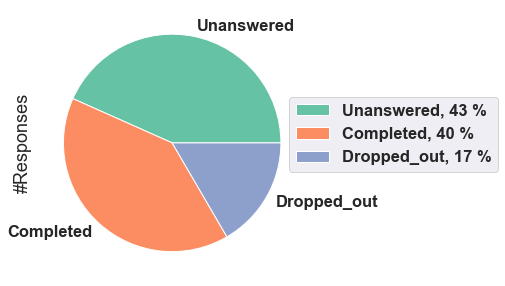

In [67]:
dfR = df['#Responses'].copy()
dfR[(dfR!=0)&(dfR!=60)]='Dropped_out'
dfR[dfR==0]='Unanswered'
dfR[dfR==60]='Completed'
dfr = dfR.value_counts().to_frame()
piep = dfr.plot.pie( y = '#Responses' ,figsize=(5, 5),colors = sns.color_palette("Set2", 3),pctdistance= 0.1)
plt.legend( bbox_to_anchor=(0.9,.7),loc = 'left', labels=['%s, %1.f %%' % (l, s) for l, s in zip(dfr.index, 100*dfr.iloc[:,0]/dfr.sum(axis=0).values)])
perc = (df['#Responses'].value_counts()[0]/df['#Responses'].value_counts().sum()*100).copy()
print('{}% of employees have left the entire survay blank.'.format(int(perc)))
perc = (df['#Responses'].value_counts()[2:].sum()/df['#Responses'].value_counts().sum()*100).copy()

print('{}% of employees have not compeleted the entire survay.'.format(int(np.round(perc,0))))
plt.show()

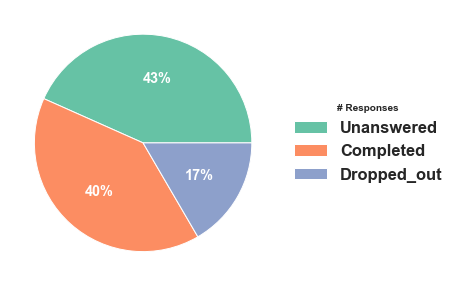

In [68]:
dfR = df['#Responses'].copy()
dfR[(dfR!=0)&(dfR!=60)]='Dropped_out'
dfR[dfR==0]='Unanswered'
dfR[dfR==60]='Completed'
dfr = dfR.value_counts().to_frame()


fig,ax=plt.subplots(1,1, figsize=(5, 5))
wedges, texts, autotexts =  ax.pie(dfr,autopct='%.0f%%',colors = sns.color_palette("Set2", 3),pctdistance= 0.6,textprops={'size': 'x-large','color':"w"})
labels = ['Unanswered','Completed','Dropped_out']
ax.legend(wedges, labels,
          title="# Responses",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          frameon = 0)




plt.show()

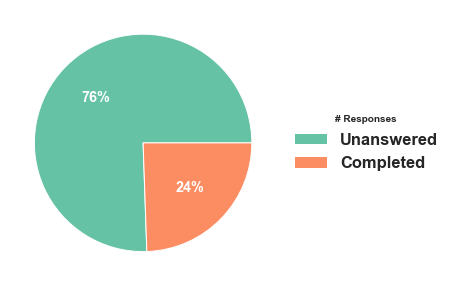

In [69]:
dfR = df['ti_unique_score'].copy()
dfR[dfR!=0] = 'Commented'
dfR[dfR==0] = 'Unanswered'

dfr = dfR.value_counts().to_frame()
fig,ax=plt.subplots(1,1, figsize=(5, 5))
wedges, texts, autotexts =  ax.pie(dfr,autopct='%.0f%%',colors = sns.color_palette("Set2", 3),pctdistance= 0.6,textprops={'size': 'x-large','color':"w"})
labels = ['Unanswered','Completed','Dropped_out']
ax.legend(wedges, labels,
          title="# Responses",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          frameon = 0)





# plt.legend( bbox_to_anchor=(0.9,.7),loc = 'left', labels=['%s, %1.f %%' % (l, s) for l, s in zip(dfr.index, 100*dfr.iloc[:,0]/dfr.sum(axis=0).values)])
plt.show()


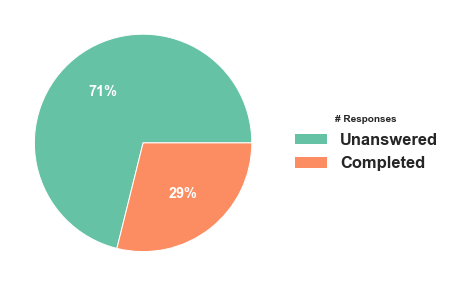

In [70]:
dfR = df['ti_change_score'].copy()
dfR[dfR!=0] = 'Commented'
dfR[dfR==0] = 'Unanswered'

dfr = dfR.value_counts().to_frame()
# piep = dfr.plot.pie( y = 'ti_change_score' ,figsize=(5, 5))
# plt.legend( bbox_to_anchor=(0.9,.7),loc = 'left', labels=['%s, %1.f %%' % (l, s) for l, s in zip(dfr.index, 100*dfr.iloc[:,0]/dfr.sum(axis=0).values)])
fig,ax=plt.subplots(1,1, figsize=(5, 5))
wedges, texts, autotexts =  ax.pie(dfr,autopct='%.0f%%',colors = sns.color_palette("Set2", 3),pctdistance= 0.6,textprops={'size': 'x-large','color':"w"})
labels = ['Unanswered','Completed','Dropped_out']
ax.legend(wedges, labels,
          title="# Responses",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          frameon = 0)

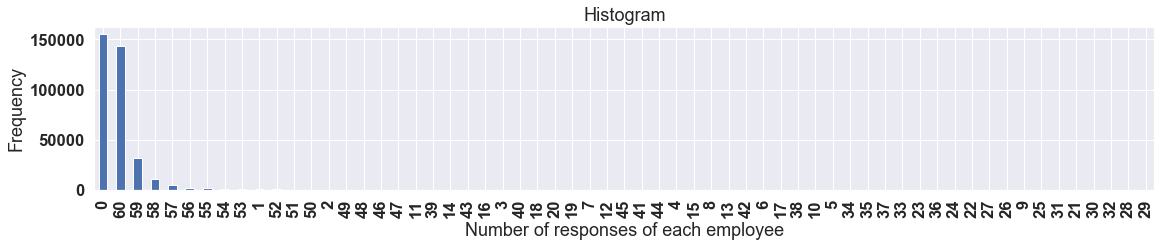

In [71]:
plt.figure(figsize=(19,3))
df['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any.

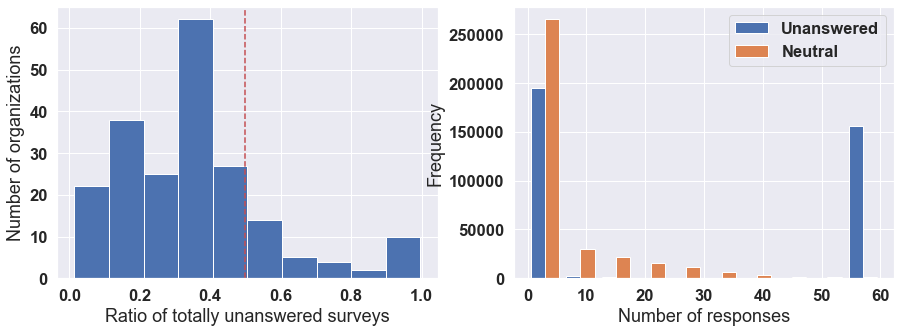

In [72]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = df[df['#Responses']==0].groupby(['Survey' ])['#Responses'].count().copy()
R = df[df['#Responses']!=0].groupby(['Survey' ])['#Responses'].count().copy()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of organizations')
ax[0].axvline(.5,linestyle='--',color='r')

s0 = (60-df['#Responses'])
s3 = df['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

> **Left figure**: If we consider different locations of different organizations, we can see the ratio of unanswered questions is mostly > 0.5.<br>
**Right figure**: The mejority of people either response to all or no questions(Blue bars). Usually people don't choose 3 as an answer(Green bars). I believe this shows that it is not a good way to consider the unanswered questions as neutral responses.

In [73]:
# fig,ax = plt.subplots(1,2,figsize=(15,5))

# NR = df[df['#Responses']==0].groupby(['Survey' ])['#Responses'].count().copy()
# a = df[df['#Responses']==0]['Survey' ].unique()
# R = df.groupby(['Survey' ])['#Responses'].count().copy()
# plt.scatter(NR,R)

In [74]:
meanPR = dfq.groupby('Categories')['Q-Score'].mean().sort_values().copy()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Q-Score']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

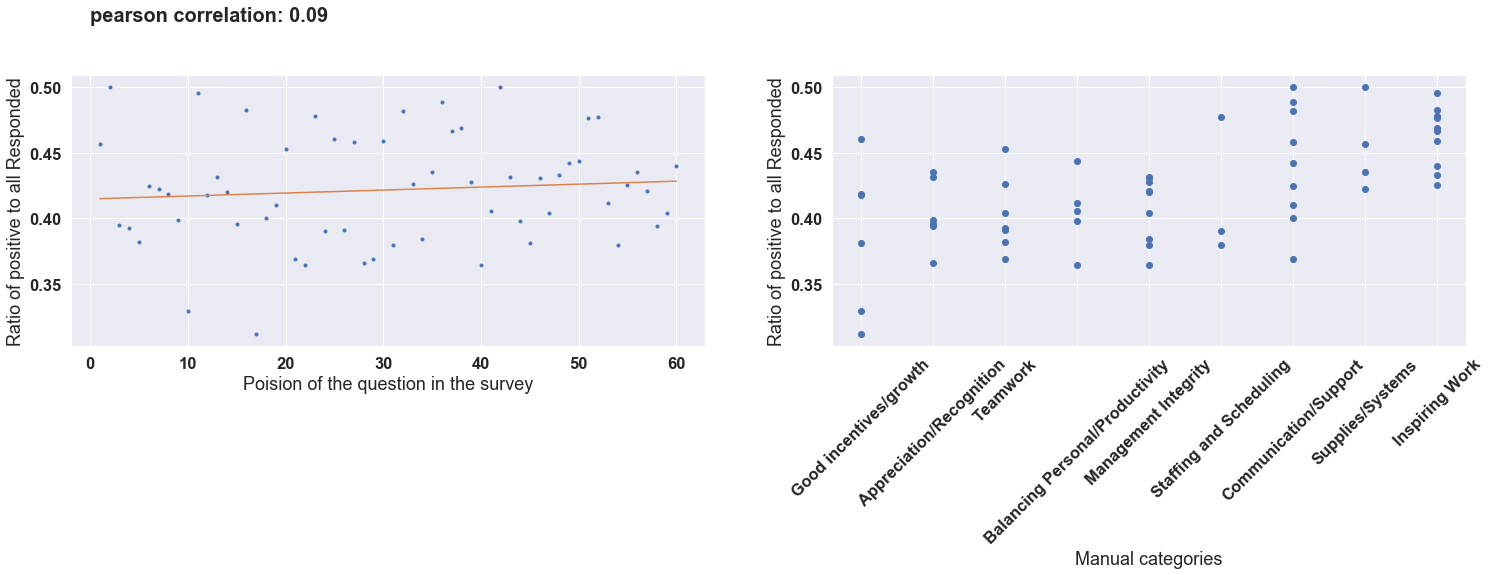

In [75]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Q_index'],dfq['Q-Score'],'.')
ax[0].plot(np.unique(dfq['Q_index']), np.poly1d(np.polyfit(dfq['Q_index'], dfq['Q-Score'], 1))(np.unique(dfq['Q_index'])))
ax[0].text(0,.55,"pearson correlation: "+str(round(np.corrcoef(dfq['Q_index'],dfq['Q-Score'])[0,1],2)),fontsize=20)
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Q-Score','mean_Q-Score']].sort_values(by='mean_Q-Score')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

> **Left figure**: Score vs. Position of question in the survey. W can not see there is no correlation between the position of the question and the owerall score of the question.<br>
**Right figure**: This figure shows that in average, there is a correlation between the scores obtained by the questions in each category and the topic of categories.

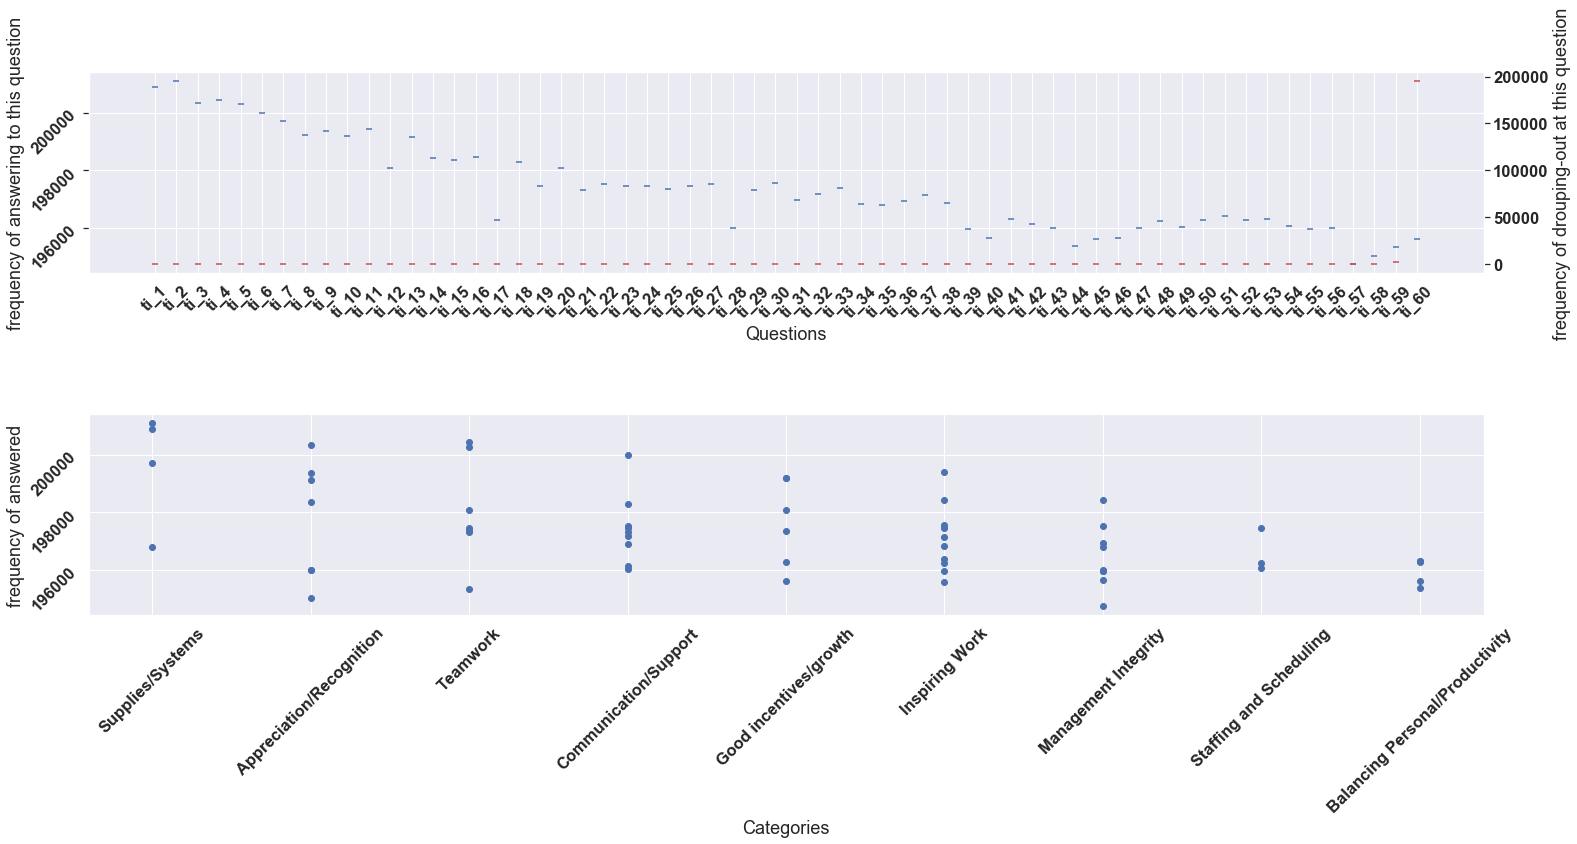

In [76]:
fig, ax = plt.subplots(2,1,figsize=(25,10))

ax00 = ax[0].twinx()
dfc = df[df['#Responses']!=0].astype(bool).sum(axis=0).to_frame('Answered')[5:65].merge(dfq[['Questions','Categories']],left_index=True,right_on='Questions').copy()
dfd = df[df['#Responses']!=0]['LeftAt'].value_counts()
dfd.index = dfd.index.astype(int)
ax00.scatter((dfd.index)-1,dfd.values,marker="_",c='r')
ax[0].scatter(x = dfc['Questions'] , y=dfc['Answered'],marker="_")
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('frequency of answering to this question')
ax[0].tick_params(labelrotation=45)
ax00.set_ylabel('frequency of drouping-out at this question')
ax00.grid(None)

ax[1].scatter(x = dfc['Categories'] , y=dfc['Answered'])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('frequency of answered')
ax[1].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=.7)
plt.show()

> This figure shows people usually left the last questions unanswered.

## Data imputation:
>  Unanswered questions:<br>
1- Can be removed<br>
2- Can be considred as neutral response 3<br>
3- Can fill in by the mode of responses<br>
4- Creating dummy features and include unanswered questions as a feature<br>
>> - In this project, based on the results above, we remove all the employees how have left the suvey before question number 55.<br>
>>- We impute the unansweed questions of the rest of the employees with the most frequent answer of that employee.


In [77]:
df_imputed = df[(df['LeftAt']>55)][Qs].copy()
employee_mode = df_imputed.mode(axis=1)
df_imputed.replace(0,employee_mode,inplace=True)

In [78]:
df_imputed0 = df[(df['#Responses']>59)][Qs].copy()

corrmat = df_imputed0.corr()
Distance_Matrix = 1-corrmat

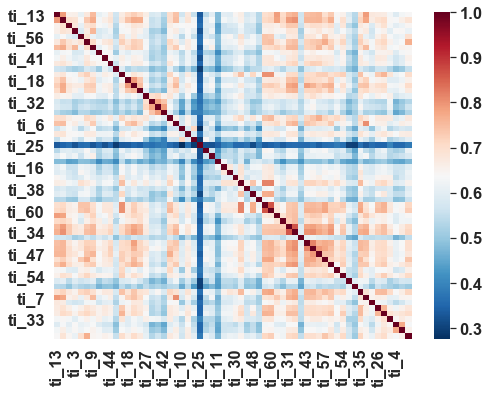

In [79]:
fig,ax =plt.subplots(1,1,figsize=(8,6))
sns.heatmap(corrmat,  cmap=pylab.cm.RdBu_r)


In [80]:
dfq[dfq['Actionable']==1][['Categories','Actionable','Text','Q-Score']].sort_values(by='Q-Score').head(60)

,Categories,Actionable,Text,Q-Score
30,Good incentives/growth,1,I feel I receive a fair share of the profits made by this organization.,0.311956
28,Good incentives/growth,1,People here are paid fairly for the work they do.,0.329236
44,Management Integrity,1,Managers avoid playing favorites.,0.364805
8,Appreciation/Recognition,1,Promotions go to those who best deserve them.,0.365700
21,Communication/Support,1,Management involves people in decisions that affect their jobs or work environment.,0.368876
54,Staffing and Scheduling,1,Management hires people who fit in well here.,0.379628
45,Management Integrity,1,Management delivers on its promises.,0.379774
32,Good incentives/growth,1,We have special and unique benefits here.,0.381149
46,Management Integrity,1,Management's actions match its words.,0.383981
52,Staffing and Scheduling,1,Management does a good job of assigning and coordinating people.,0.390635


## Target variable
>In this section, we are looking for a measure to label the data, to develop a supervised ML model for that.<br>

>- On option is the score of each person, that is the ratio of positive responses to the number of responded questions. The problem with this score is that there are some non-actionable questions in the survey and using these questions in the scoring system would not help to improve the results we are going to interpret from the ML model.<br>
>- base on the description above, one scoring system is the ratio of positive actionable responses to all of the actionable responses.<br>
>- Last question of the survey asked employees "Taking everything into account, I would say this is a great place to work". This qistion is also a good feature to be used as a target variable.

In [81]:
# fig , ax = plt.subplots(2,6,figsize=(35,5),sharex=True,sharey=True)

# for i in range(6):
#     sns.barplot(x=Qs, y=df[df['ti_60']==i][Qs].mean(),ax=ax[0,i])
#     sns.barplot(x=Qs, y=df[(df['E-Score']<=(i)*.2) & (df['E-Score']>(i-1)*.2)][Qs].mean(),ax=ax[1,i])

Text(0, 0.5, 'E-Score')

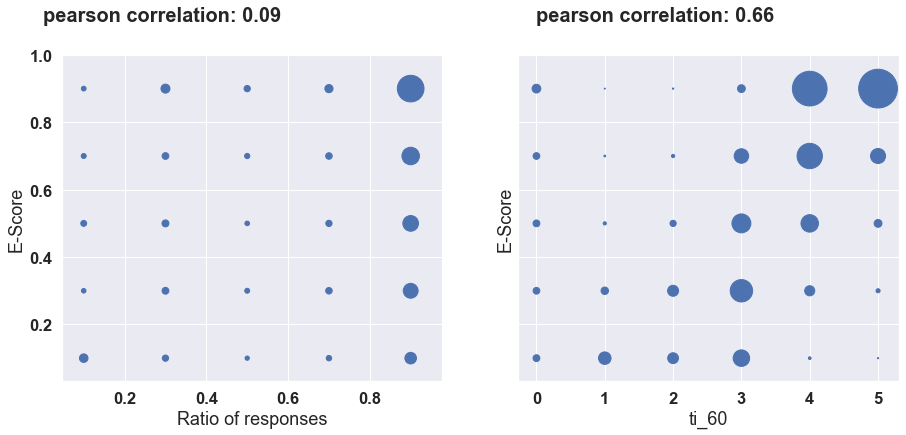

In [82]:
fig , ax = plt.subplots(1,2,figsize=(15,6),sharex=False,sharey=True)

X = (df['#Responses']/60).copy()
Y = (df['E-Score']).copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) ,.2)+.1
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X)+.2 ,.2) -.05
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X, Y, bins=(xedges, yedges))
ax[0].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/5)
ax[0].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[0].set_xlabel('Ratio of responses')
ax[0].set_ylabel('E-Score')

X = df['ti_60'].copy()
Y = df['E-Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[1].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/20)
ax[1].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[1].set_xlabel('ti_60')
ax[1].set_ylabel('E-Score')


> This figure shows:<br>
**Left figure:** There is no correlation between the number of responses and the finall score.<br>
**Middle figure:** There is a correlation between the finall score and employees response to the question they rank overally their workplace.<br>
**Right figure:** There is also a high correlation between the finall score and the actionable finall score.<br>

In [83]:
df['Target'] = df['E-Score']>np.median(df['E-Score'].dropna())

### Number of unique rows

In [102]:
df_rows = df.drop_duplicates()
df_rows.shape
df_rows = df.iloc[:,5:64].drop_duplicates()
df_rows.shape

(172879, 59)

## Machine learning model development

In [92]:
def ML_dev(x,y,ML_name):
    """
    input
    """
    pickle_key='ML_'+ML_name+'.pkl'
    path_pickle = '../../data/pickles/'
    pickle_location_AWS = 's3://{}/{}'.format(bucket, pickle_key)
    pickle_location_local = path_pickle+pickle_key


    try:
        if ~AWS:
            with open(pickle_location_local, 'rb') as file:
                XGB_GridSearch = pickle.load(file)
                file.close()
            print('Loading Model from pickle ...')
        else:
            response = s3client.get_object(Bucket=bucket, Key=pickle_key)
            body = response['Body'].read()
            XGB_GridSearch = pickle.loads(body)
            print('Loading pickle ...')            
    except:
        print('Training model ...')
        # Create training and validation sets
        X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
        estimator = xgb.XGBRegressor(random_state=2)
        
        param_grid = {
            'max_depth': [ 4, 5,7,10],
            'n_estimators': [10, 50,100,200],
            'min_samples_split':[5,8,10],
        }
#         param_grid = {
#             'max_depth': [ 5],
#             'n_estimators': [100],
#             'min_samples_split':[5],
#         }
        XGB_GridSearch = GridSearchCV(estimator, param_grid, cv=5,n_jobs=-1,verbose=10)
        XGB_GridSearch.fit(X_train, y_train)
        if ~AWS:
            pickle.dump(XGB_GridSearch, open(pickle_location_local, 'wb'))
            print('Storing pickle ...')            

        else:
            print('Storing pickle ...')            
            pickle.dump(XGB_GridSearch, open(pickle_location_AWS, 'wb'))
            s3_resource = boto3.resource('s3')
            s3_resource.Object(bucket,pickle_name).put(Body=open(pickle_name, 'rb'))
    return XGB_GridSearch,X_train, X_test, y_train, y_test

### ML on all of the questions

> In this sesction I am going to apply the RandomForest Classifier, to find the most important questions that can predict the actionable score.

In [93]:
# Prepare the data
df_imputed = df[(df['#Responses']>59)][Qs].copy()
# df_0 = df_imputed.copy()
# df_1 = df[(df['#Responses']>59)].loc[:,['LeftAt']].copy()
# x = pd.merge(df_0,df_1,right_index=True,left_index=True)
x = df_imputed.copy()
y = df[(df['#Responses']>59)].loc[:,'E-Score'].copy()
XGB_all_Qs, X_train, X_test, y_train, y_test = ML_dev(x,y,'_all_Qs')


Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.3s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


[23:11:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...


In [94]:
print('Best parameters found by grid search are:', XGB_all_Qs.best_params_)
y_predict = XGB_all_Qs.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = XGB_all_Qs.best_estimator_.score(X_train,y_predict)

y_predict = XGB_all_Qs.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = XGB_all_Qs.best_estimator_.score(X_test,y_predict)

print('The mean squared error for the random forest model:')
print('on the train dataset is: ',mean_squared_error(XGB_all_Qs.best_estimator_.predict(X_train),y_train))
print('on the test dataset is: ',mean_squared_error(XGB_all_Qs.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score:')
print('on the train dataset is: ',np.corrcoef(XGB_all_Qs.best_estimator_.predict(X_train),y_train)[0,1])
print('on the test dataset is: ',np.corrcoef(XGB_all_Qs.best_estimator_.predict(X_test),y_test)[0,1])

Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
The mean squared error for the random forest model:
on the train dataset is:  0.00018429933163762095
on the test dataset is:  0.00022455853694511226
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.998881083257618
on the test dataset is:  0.9986507455374849


Feature ranking:


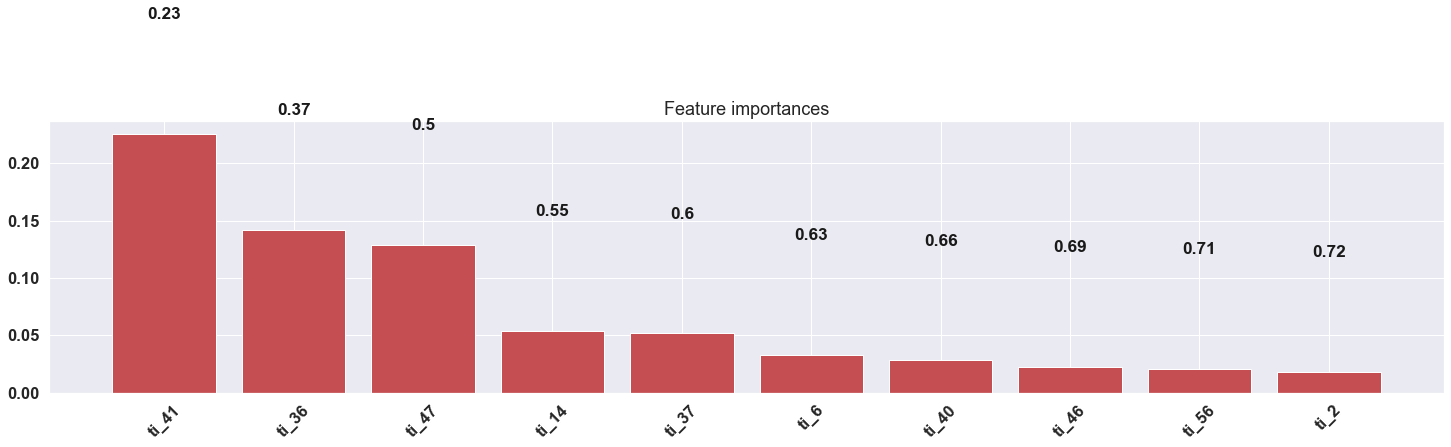

In [95]:
features = dfq[['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values
# features=np.append(features,['LeftAt'])
importances= XGB_all_Qs.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[:10], importances[indices][:10],
        color="r", align="center")
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices))[:10], features[indices][:10])
plt.xticks(rotation=45)
pos = range(X_train.shape[1])[:10]
perc = importances[indices]
cumsum_perc = np.cumsum(importances[indices]).round(2)
for tick in pos:
    plt.text(pos[tick], perc[tick] + .1, cumsum_perc[tick], horizontalalignment='center', size='xx-large', color='k', weight='semibold')

plt.show()


In [96]:
dfq.sort_values(by = 'Q_index', ascending=True,inplace=True)

dfq.iloc[indices,:][['Questions','Actionable','Text']]


,Questions,Actionable,Text
56,ti_41,1,People are encouraged to balance their work life and their personal life.
24,ti_36,1,People here are treated fairly regardless of their gender.
50,ti_47,1,"Management shows a sincere interest in me as a person, not just an employee."
43,ti_14,1,Management recognizes honest mistakes as part of doing business.
37,ti_37,0,I'm proud to tell others I work here.
18,ti_6,1,Management makes its expectations clear.
55,ti_40,0,People avoid politicking and backstabbing as ways to get things done.
49,ti_46,1,Management is honest and ethical in its business practices.
9,ti_56,0,"Our customers would rate the service we deliver as ""excellent."""
1,ti_2,1,This is a physically safe place to work.


### ML on actionable questions

In [98]:
df_imputed = df[(df['#Responses']>59)][Qs].copy()

x = df_imputed[aQs].copy()
y = df[(df['#Responses']>59)].loc[:,'E-Score'].copy()
# Create training and validation sets

In [99]:
XGB_actionable_questions, X_train, X_test, y_train, y_test = ML_dev(x,y,'_actionable_questions')

Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   38.8s remaining:   58.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   39.0s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


[23:13:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...


In [100]:
print('Best parameters found by grid search are:', XGB_actionable_Qs.best_params_)
y_predict = XGB_actionable_Qs.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = XGB_actionable_Qs.best_estimator_.score(X_train,y_predict)

y_predict = XGB_actionable_Qs.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = XGB_actionable_Qs.best_estimator_.score(X_test,y_predict)

print('The mean squared error for the random forest model:')
print('on the train dataset is: ',mean_squared_error(XGB_actionable_Qs.best_estimator_.predict(X_train),y_train))
print('on the test dataset is: ',mean_squared_error(XGB_actionable_Qs.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score:')
print('on the train dataset is: ',np.corrcoef(XGB_actionable_Qs.best_estimator_.predict(X_train),y_train)[0,1])
print('on the test dataset is: ',np.corrcoef(XGB_actionable_Qs.best_estimator_.predict(X_test),y_test)[0,1])


NameError: name 'XGB_actionable_Qs' is not defined

In [ ]:
features = dfq[dfq['Questions'].isin(aQs)][['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values
# features=np.append(feature,['#Responses','LeftAt'])
importances= XGB_actionable_Qs.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[:10], importances[indices][:10], )
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices))[:10], features[indices][:10])
plt.xticks(rotation=45)

pos = range(X_train.shape[1])[:10]
perc = importances[indices]
cumsum_perc = np.cumsum(importances[indices]).round(2)
for tick in pos:
    plt.text(pos[tick], perc[tick] + .1, cumsum_perc[tick], horizontalalignment='center', size='xx-large', color='k', weight='semibold')
plt.show()

In [ ]:
dfq.sort_values(by = 'Q_index', ascending=True,inplace=True)
dfq1 = dfq[dfq['Questions'].isin(aQs)].iloc[indices,:][['Questions','Actionable','Text']].copy()
pickle_key = 'Important_questions.pkl'
pickle_location_local = path_pickle+pickle_key
if AWS:
    dfq1.to_pickle(pickle_key)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket,pickle_key).put(Body=open(pickle_key, 'rb'))
else:
    dfq1.to_pickle(pickle_location_local)  
dfq1['Text'].to_frame()

In [ ]:
dfq[dfq['Questions'].isin(aQs)].iloc[indices,:]['Categories'][:10].value_counts()

In [ ]:
set(dfq[dfq['Questions'].isin(aQs)].iloc[indices,:]['Categories'].unique())-set(dfq[dfq['Questions'].isin(aQs)].iloc[indices,:]['Categories'][:10].unique())


In [ ]:
# df[df[col_list]>3][col_list] = 'Positive'
# df[df[col_list]==3][col_list] = 'Neutral'
# df[(df[col_list]<3)&(df[col_list]!=0)][col_list] = 'Negative'
# df[df[col_list]==0][col_list] = 'Unanswered'

In [ ]:
importantfeatures = [33,42,56,8,48,53,25,21,51,16];

In [ ]:
dfq.iloc[importantfeatures,:][['Questions','Actionable','Text']]


In [ ]:
# dummy variables based on nested trust indicies.
dummy_aQs = []

cols = aQs[indices[:10]]
new_col = list(map(lambda x:str(x)+'_positive',cols))
df[new_col]  = df[cols]>3
dummy_aQs = dummy_aQs+new_col

new_col = list(map(lambda x:str(x)+'_negative',cols))
df[new_col]  = ((df[cols]<3) & (df[cols]!=0))
dummy_aQs = dummy_aQs+new_col

new_col = list(map(lambda x:str(x)+'_neutral',cols))
df[new_col]  = df[cols]==3
dummy_aQs = dummy_aQs+new_col

new_col = list(map(lambda x:str(x)+'_unanswered',cols))
df[new_col]  = df[cols]==0
dummy_aQs = dummy_aQs+new_col


## Machine learning model development
### on binerized 10 most important questions

In [ ]:
# Prepare the data
df_imputed = df[(df['#Responses']>59)].copy()

x = df_imputed.loc[:,dummy_aQs].copy()
y = df_imputed.loc[:,'E-Score'].copy()
XGB_overall_score, X_train, X_test, y_train, y_test = ML_dev(x,y,'_overall_score')
print('Best parameters found by grid search are:', XGB_overall_score.best_params_)

In [ ]:
print('The mean squared error for the Gradient Boosting model:')
print('on the train dataset is: ',mean_squared_error(XGB_overall_scores.best_estimator_.predict(X_train),y_train))
print('on the test dataset is: ',mean_squared_error(XGB_overall_scores.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score:')
print('on the train dataset is: ',np.corrcoef(XGB_overall_scores.best_estimator_.predict(X_train),y_train)[0,1])
print('on the test dataset is: ',np.corrcoef(XGB_overall_scores.best_estimator_.predict(X_test),y_test)[0,1])


In [ ]:
features = np.array(dummy_aQs)
importances= XGB_overall_scores.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
ii = 35 
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(30,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[:ii], importances[indices][:ii], )
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices))[:ii], features[indices][:ii])
plt.xticks(rotation=45)

pos = range(X_train.shape[1])[:ii]
perc = importances[indices].round(2)
cumsum_perc = np.cumsum(importances[indices]).round(2)
for tick in pos:
    plt.text(pos[tick], perc[tick] + .02, perc[tick], horizontalalignment='center', size='x-large', color='k', weight='semibold')
plt.show()

## Develop ML models to predict categories scores

In [ ]:
mse_test = []
mse_train = []
for i,cat in enumerate(qcategories):
    print(cat)
    x = df_imputed.loc[:,dummy_aQs].copy()
    y = df_imputed.loc[:,escat[i]].copy()

    model_cat, X_train, X_test, y_train, y_test = ML_dev(x,y,'Category'+str(i))

    mse_train.append(mean_squared_error(model_cat.best_estimator_.predict(X_train),y_train))
    mse_test.append(mean_squared_error(model_cat.best_estimator_.predict(X_test),y_test))
    print('The mean squared error for the Gradient Boosting model:')
    print('on the train dataset is: ',mean_squared_error(model_cat.best_estimator_.predict(X_train),y_train))
    print('on the test dataset is: ',mean_squared_error(model_cat.best_estimator_.predict(X_test),y_test))
    print('The pearson correlation coefficient between the predicted and real score:')
    print('on the train dataset is: ',np.corrcoef(model_cat.best_estimator_.predict(X_train),y_train)[0,1])
    print('on the test dataset is: ',np.corrcoef(model_cat.best_estimator_.predict(X_test),y_test)[0,1])
    
    

In [ ]:
dfmse = pd.DataFrame({'Categories':qcategories,'Train':mse_train,'Test':mse_test})
dfmse.iloc[:,1:3]=np.round(dfmse.iloc[:,1:3]*100,1)
dfmse

## Develop ML models to predict inconsistancy score

In [ ]:
df_imputed = df[(df['#Responses']>59)].copy()
mse_test_5 = []
mse_train_5 = []
np.random.seed(1)
most_imortant_aQs =  aQs[indices[:10]].copy()
for i in range(12):
    print(i)
    # dummy variables based on nested trust indicies.
    dummy_aQs = []
    most_imortant_aQs =  aQs[indices[:10]].copy()

    cols = np.random.choice(most_imortant_aQs,5,replace=False)
    print(cols)
    new_col = list(map(lambda x:str(x)+'_positive',cols))
    df_imputed[new_col]  = df_imputed[cols]>3
    dummy_aQs = dummy_aQs+new_col

    new_col = list(map(lambda x:str(x)+'_negative',cols))
    df_imputed[new_col]  = ((df_imputed[cols]<3) & (df_imputed[cols]!=0))
    dummy_aQs = dummy_aQs+new_col

    new_col = list(map(lambda x:str(x)+'_neutral',cols))
    df_imputed[new_col]  = df_imputed[cols]==3
    dummy_aQs = dummy_aQs+new_col

    new_col = list(map(lambda x:str(x)+'_unanswered',cols))
    df_imputed[new_col]  = df_imputed[cols]==0
    dummy_aQs = dummy_aQs+new_col

    print(len(list(set(dummy_aQs)-set(df_imputed.columns.values))))
    x = df_imputed.loc[:,dummy_aQs].copy()
    y = df_imputed.loc[:,'E-Score'].copy()
    # Create training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
    model_rand, X_train, X_test, y_train, y_test = ML_dev(x,y,'Category'+str(i))
    
    mse_train_5.append(mean_squared_error(model_rand.best_estimator_.predict(X_train),y_train))
    mse_test_5.append(mean_squared_error(model_rand.best_estimator_.predict(X_test),y_test))
    print('The mean squared error for the Gradient Boosting model:')
    print('on the train dataset is: ',mean_squared_error(model_rand.best_estimator_.predict(X_train),y_train))
    print('on the test dataset is: ',mean_squared_error(model_rand.best_estimator_.predict(X_test),y_test))
    print('The pearson correlation coefficient between the predicted and real score:')
    print('on the train dataset is: ',np.corrcoef(model_rand.best_estimator_.predict(X_train),y_train)[0,1])
    print('on the test dataset is: ',np.corrcoef(model_rand.best_estimator_.predict(X_test),y_test)[0,1])
    
    

In [ ]:
x = np.zeros([5,4])
x=x.T.reshape(1,-1)

directory_name='../pickles/'
np.random.seed(1)
resultm = np.zeros(12)
for i in range(12):
    print(i)
    pickle_name = str(i)+'_5'+'_XGB.pkl'
    loaded_model = pickle.load(open(pickle_name, 'rb'))
    dummy_aQs = loaded_model.best_estimator_.get_booster().feature_names
    dfx = pd.DataFrame(x,columns=dummy_aQs)

    
    resultm[i] = loaded_model.best_estimator_.predict(dfx)
# resultm
# dfm = pd.DataFrame(data=np.round(resultm*100,1),index=np.insert(qcategories,0,'Overall')).reset_index()
# dfm.columns=['Categories','percentage']
# dfm1 = dfr[dfr['Categories']!='Overall'].sort_values(by='percentage')
# dfm1 = dfm1.append(dfm[dfm['Categories']=='Overall'])


In [ ]:
plt.hist(resultm*100)

In [ ]:
mse_train_5

In [ ]:
dfmse_5 = pd.DataFrame({'ML#':range(12),'Train':mse_train_5,'Test':mse_test_5})
dfmse_5.iloc[:,1:3]=np.round(dfmse_5.iloc[:,1:3]*100,1)
dfmse_5

In [ ]:
result = np.array([.1,.2,.3,.4,.5,.6,.6,.7,.8,.9,1])#np.random.random(10)#;

dfr = pd.DataFrame(data=np.round(result*100,1))

zz = (dfr//10).iloc[:,0].values.astype(int).tolist()
print(zz)
# import plotly.express as px
colorz = px.colors.diverging.RdYlGn
colorz = np.array(colorz)[zz]

colorz =[str(i) for i in colorz]

fig = px.bar(x=dfr.iloc[:,0],y=dfr.index.values,orientation='h')
fig.update_traces(marker_color=colorz)
fig.update_layout(
    title="Predicted",
    xaxis_title="Score(%)",
    yaxis_title="Categories",
    font=dict(
        size=18,
        color="#7f7f7f"
    )
)

In [ ]:
dfc = df.copy()
1
dfc[dfc[Qs]==0]=np.nan
2
result0 = dfc.groupby(["Survey"])['id'].count().to_frame('tot').reset_index()
3
result = dfc[dfc['#Responses']!=0].groupby(["Survey"])['E-Score'].agg(['mean','count']).reset_index().sort_values('mean')
4
result = result.merge(result0,how='outer')

In [ ]:
plt.figure(figsize=(32,8))
rez1 = result[result['mean']<.63]
dfcc = dfc[dfc['Survey'].isin(rez1['Survey'].values)]
ax = sns.barplot(x="Survey", y='E-Score', data=dfcc,order=rez1['Survey'])


medians = rez1.iloc[:,1]
nobs = rez1.iloc[:,2].astype(pd.Int32Dtype())
nobs0 = rez1.iloc[:,3].astype(pd.Int32Dtype())
nob0 = ["Totall: " + str(s) for s in list(nobs0)]
nob = ["Answered: " + str(s) for s in list(nobs)]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] - .1, nob0[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
    ax.text(pos[tick], medians[tick] - .2, nob[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
ax.set(ylabel='Ratio dissatisfied')
plt.xticks(rotation=25)
    
plt.show()

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(25,15))

resultdep = (dfc[dfc["Survey"]==result.iloc[0,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dfc[dfc["Survey"]==result.iloc[0,0]][Qs]>0).sum(axis=0)).sort_values()

sns.barplot(x = resultdep.index,y=resultdep.values,ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_title('{} Department'.format(result.iloc[0,0]))
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('Relative frequency of positivity')
idx0 = [int(i.split("_")[1])-1 for i in resultdep.index[:6]]


resultdep = (dfc[dfc["Survey"]==result.iloc[1,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dfc[dfc["Survey"]==result.iloc[1,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[1])
ax[1].tick_params(labelrotation=45)
ax[1].set_title('{} Department'.format(result.iloc[1,0]))
ax[1].set_xlabel('Questions')
ax[1].set_ylabel('Relative frequency of positivity')
idx1 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]


resultdep = (dfc[dfc["Survey"]==result.iloc[2,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dfc[dfc["Survey"]==result.iloc[2,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[2])
plt.xticks(rotation=45)
plt.title('{} Department'.format(result.iloc[2,0]))
ax[2].set_xlabel('Questions')
ax[2].set_ylabel('Relative frequency of positivity')
idx2 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]

plt.subplots_adjust(hspace=.7)
plt.show()

In [ ]:
print('Organization {}'.format(result.iloc[1,0]))
dfq.iloc[idx1,:]['Text'].to_frame()

---
---



---
# Analyzing the data based on organization of care services

In [ ]:
print('Enter Id of the organization. A number from {} to {}:'.format(np.unique(df['Survey']).min(),np.unique(df['Survey']).max()))
Org = input()
print('From organization {} you can select one of the locations:'.format(Org))
loc = df[df['Survey']==int(Org)]['Location Name'].value_counts()
listt = list(zip(loc.index.values,loc.values))
dfc = pd.DataFrame(listt, columns = ['Location Name', '#Employees']) 
print(dfc)
print('Enter Id of the locatiom:')
loci = input()

print('You have chosen location {} from organization {}.'.format(dfc.iloc[int(loci),0],int(Org)))


In [ ]:
dforg = df[(df['Survey']==int(Org))]
dfloc = df[(df['Survey']==int(Org)) & (df['Location Name']== dfc.iloc[int(loci),0])]

In [ ]:
plt.figure(figsize=(19,5))
dforg['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any.

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(25,10))

dforgc = dforg.astype(bool).mean(axis=0).to_frame('Answered')[5:65].merge(dfq[['Questions','Categories']],left_index=True,right_on='Questions')

ax[0].scatter(x = dforgc['Questions'] , y=dforgc['Answered'])
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('frequency of answered')
ax[0].tick_params(labelrotation=45)

ax[1].scatter(x = dforgc['Categories'] , y=dforgc['Answered'])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('frequency of answered')
ax[1].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=.7)
plt.show()

> In overall analysis we see that, people usually left the last questions unanswered.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = dforg[dforg['#Responses']==0].groupby(['Survey' , 'Location Name'])['#Responses'].count()
R = dforg[dforg['#Responses']!=0].groupby(['Survey' , 'Location Name'])['#Responses'].count()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of locations')
ax[0].axvline(.5,linestyle='--',color='r')

s0 = (60-dforg['#Responses'])
s3 = dforg['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

> **Left figure**: If we consider different locations of This organizations, we can see the majority of the locations has a small (e.i. < 0.5) ratio of unanswered questions.<br>
**Right figure**: The mejority of people either response to all or no questions(Blue bars). Usually people don't choose 3 as an answer(Green bars). I believe this shows that it is not a good way to consider the unanswered questions as neutral responses.

In [ ]:
dfq.drop(columns=['mean_Q-Score','Q-Score'],inplace=True)
dfq = dfq.merge((dforg[dforg[Qs]!=0][Qs]>3).mean().to_frame('Q-Score'),left_on='Questions',right_index=True)
meanPR = dfq.groupby('Categories')['Q-Score'].mean().sort_values()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Q-Score']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Q_index'],dfq['Q-Score'],'.')
# ax[0].plot(np.unique(dfq['Q_index']), np.poly1d(np.polyfit(dfq['Q_index'], dfq['Q-Score'], 1))(np.unique(dfq['Q_index'])))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Q-Score','mean_Q-Score']].sort_values(by='mean_Q-Score')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

# Clustering the questions besed on their mutual information
> We use Mutual Information as a measure of distance between sets of responses of each question. Actually a normalized metricated variant of mutual information is an entropic Jaccard distance.

In [ ]:
df_non0 = dforg[dforg['#Responses']!=0][Qs].T
d = distance.pdist(df_non0, metric='jaccard')
Distance_Matrix = distance.squareform(d)

In [ ]:
plt.figure(figsize=(10,7))

sns.heatmap(Distance_Matrix)
# for i in ct: 
#     plt.axhline(ct[:i].sum(),linestyle='--')
#     plt.axvline(ct[:i].sum(),linestyle='--')

> This figure shows the distance matrix of question, which shows how far questions from each other.

In [ ]:
agg = AgglomerativeClustering( affinity='precomputed', linkage = 'average')
agg.fit_predict(Distance_Matrix)
dis = squareform((Distance_Matrix).round(2))
Z = linkage(dis,method="complete")

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ZZ = dendrogram(
    Z,
    color_threshold=0.45,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

> Dendogram illustrate the clusters of the questions. The dendogram colored when the tree is cut at .45.

In [ ]:
max_d = .50
clusters = fcluster(Z, max_d, criterion='distance')
dfq['Clusters'] = clusters.T
clusters

In [ ]:
### Elbow Method

In [ ]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.legend(['',''])
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [ ]:
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))

ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Z = sch.linkage(dis, method="complete")
Z1 = dendrogram(
    Z,
    color_threshold=0.4,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    orientation='left'
)
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z = sch.linkage(dis, method="complete")
Z2 = dendrogram(
    Z,
    color_threshold=0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = Distance_Matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('dendrogram.png')

> the clustered distance matrix and the mapping of the clusters are illustrated.

In [ ]:
dfq.groupby('Clusters')['Q-Score'].mean()

> In the table below, you can see the questions which are categoried based on their cluster and their scare.

In [ ]:
dfq[['Clusters','Actionable','Text','Q-Score']].sort_values(by='Q-Score').sort_values(by='Clusters').head(60)

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,9))
dfq = dfq.sort_values(by='Q_index')
x= np.arange(60)
y = label_encoder.fit_transform(dfq['Categories'])

ax[0].plot(x,y,color='b',marker='o')
ax[0].set_yticks(np.arange(len(dfq['Categories'].unique())))
ax[0].set_yticklabels(sorted(dfq['Categories'].unique()))
# ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Categories')
ax0 = ax[0].twinx()
ax0.scatter(x,dfq['Clusters'],color='r',marker='o')
ax0.set_ylabel('Cluster')

PR_Catg = dfq[['Clusters','Q-Score']].sort_values(by='Clusters')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('E-Score')
# ax[1].set_ylabel('Ratio of positive to all Responded questions')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace=.3)
plt.show()

In [ ]:
df['Target'] = df['E-Score']>np.median(df['E-Score'].dropna())

In [ ]:
df['Target'].value_counts()

In [ ]:
fig , ax = plt.subplots(2,10,figsize=(55,10),sharex=True,sharey=True)
ii=-1
for i in range(20,30):
    ii +=1
    sns.barplot(x = df0[Qs[i]].unique(),y = df0[Qs[i]].value_counts(),ax=ax[0,ii])
    sns.barplot(x = df1[Qs[i]].unique(),y = df1[Qs[i]].value_counts(),ax=ax[1,ii])
plt.show()
    
    

In [ ]:
df0 = df[(df['Survey']==1)&(df['LeftAt']>59)&(df['Target']==0)][Qs].copy()
df1 = df[(df['Survey']==1)&(df['LeftAt']>59)&(df['Target']==1)][Qs].copy()

In [ ]:
# chi_square_of_df_cols(df0[i], df1[i])
pval = np.zeros([len(Qs),100])
ii = -1
for i in Qs:
    ii += 1
#     print(i)
    for j in range(50):
        chi2, pval[ii,j], dof, ex = scs.chi2_contingency(
            [
                [sum((df0[i] == cat0)) for cat0 in range(6)],
                [sum((df1[i] == cat1)) for cat1 in range(6)]
            ])

In [ ]:
plt.figure(figsize=(35,5))
plt.errorbar(x=Qs, y=pval.mean(axis=1), yerr=pval.std(axis=1)/np.sqrt(2000))
plt.xticks(rotation=45)
plt.ylabel('$\chi^2$')
plt.xlabel('Questions')
plt.title(np.array(Qs)[pval.mean(axis=1)>1e-82][0])
plt.show()

In [ ]:
np.array(Qs)[pval.mean(axis=1)>1e-9]

In [ ]:
dfq[dfq['Questions']==np.array(Qs)[pval.mean(axis=1)>1e-9][1]]['Text']

## Machine learning model development

> In this sesction I am going to apply the RandomForest Classifier, to find the most important questions that can predict the actionable score.

In [ ]:
# Prepare the data
df_non0 = dforg[dforg['#Responses']>5]
x = df_non0.loc[:,Qs+['#Responses','LeftAt']]
y = df_non0['E_Score']
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [ ]:
# lab_enc = preprocessing.LabelEncoder()
# y_train_encoded = lab_enc.fit_transform(y_train).astype('int')

In [ ]:
estimator = RandomForestRegressor(random_state=2)
param_grid = {
    'max_depth': [2,3, 4, 5],
    'n_estimators': [3, 5,10,50,100],
    'min_samples_split':[5,8,10],
}

RF = GridSearchCV(estimator, param_grid, cv=5,n_jobs=-1,verbose=10)
RF.fit(X_train, y_train)

print('Best parameters found by grid search are:', RF.best_params_)

In [ ]:

y_predict = RF.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = RF.best_estimator_.score(X_train,y_predict)

y_predict = RF.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = RF.best_estimator_.score(X_test,y_predict)

print('The mean squared error on the train dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_train),y_train))
print('The pearson correlation coefficient between the predicted and real score on the train dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_train),y_train)[0,1])
print('The mean squared error on the test dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score on the test dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_test),y_test)[0,1])

In [ ]:
features = dfq[['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values

features = np.append(features, ['#Responses','LeftAt'])

In [ ]:
features

In [ ]:


importances= RF.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices)), features[indices])
plt.xticks(rotation=45)
plt.show()

In [ ]:
features[indices][:40]

In [ ]:
# idx = [int(i.split("_")[1])-1 for i in features[indices][:40]]
# dfq.reset_index(inplace=True)
idxf = np.isin(features[indices],Qs)
# dfq.iloc[idx,:][['Questions','Actionable','Text']]#.to_frame()
dfq['Questions' == idxf][['Questions','Actionable','Text']]#.to_frame()

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,6),sharex=False,sharey=True)
for i in range(3):
    X = dforg.iloc[:,5+idx[i]].copy()
    Y = dforg['E_Score'].copy()
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]

    xedges = np.arange(0, np.max(X) + 1,1)
    yedges = np.arange(0, np.max(Y) ,.2)+.1
    meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
    xedges = np.arange(0, np.max(X) + 1.5,1) -.5
    yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

    H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
    ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*2)
    ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
    ax[i].set_xlabel('ti_{}'.format(idx[i]))
    ax[i].set_ylabel('E-Score')
i = 3    
X = dforg.iloc[:,5+50].copy()
Y = dforg['E_Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*2)
ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[i].set_xlabel('ti_{}'.format(60))
ax[i].set_ylabel('E-Score')
plt.show()

---
---
---
# Analyzing the data based on organization and location of care services

In [ ]:
print('Enter Id of the organization. A number from {} to {}:'.format(np.unique(df['Survey']).min(),np.unique(df['Survey']).max()))
Org = input()
print('From organization {} you can select one of the locations:'.format(Org))
loc = df[df['Survey']==int(Org)]['Location Name'].value_counts()
listt = list(zip(loc.index.values,loc.values))
dfc = pd.DataFrame(listt, columns = ['Location Name', '#Employees']) 
print(dfc)
print('Enter Id of the locatiom:')
loci = input()

print('You have chosen location {} from organization {}.'.format(dfc.iloc[int(loci),0],int(Org)))


In [ ]:
dfloc = df[(df['Survey']==int(Org)) & (df['Location Name']== dfc.iloc[int(loci),0])].copy()

In [ ]:
plt.figure(figsize=(19,5))
dfloc['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any. 

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(25,10))

dflocc = dfloc.astype(bool).mean(axis=0).to_frame('Answered')[5:65].merge(dfq[['Questions','Categories']],left_index=True,right_on='Questions')

ax[0].scatter(x = dflocc['Questions'] , y=dflocc['Answered'])
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('frequency of answered')
ax[0].tick_params(labelrotation=45)

ax[1].scatter(x = dflocc['Categories'] , y=dflocc['Answered'])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('frequency of answered')
ax[1].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=.7)
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = dfloc[dfloc['#Responses']==0].groupby(['Survey' , 'Department Name'])['#Responses'].count()
R = dfloc[dfloc['#Responses']!=0].groupby(['Survey' , 'Department Name'])['#Responses'].count()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of Departments')
ax[0].axvline(.5,linestyle='--',color='r')

s0 = (60-dfloc['#Responses'])
s3 = dfloc['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

In [ ]:
dfq.drop(columns=['mean_Q-Score','Q-Score'],inplace=True)
dfq = dfq.merge((dfloc[dfloc[Qs]!=0][Qs]>3).mean().to_frame('Q-Score'),left_on='Questions',right_index=True)
meanPR = dfq.groupby('Categories')['Q-Score'].mean().sort_values()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Q-Score']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Q_index'],dfq['Q-Score'],'.')
# ax[0].plot(np.unique(dfq['Q_index']), np.poly1d(np.polyfit(dfq['Q_index'], dfq['Q-Score'], 1))(np.unique(dfq['Q_index'])))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Q-Score','mean_Q-Score']].sort_values(by='mean_Q-Score')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

# Clustering the questions besed on their mutual information
> We use Mutual Information as a measure of distance between sets of responses of each question. Actually a normalized metricated variant of mutual information is an entropic Jaccard distance.

In [ ]:
# df_non0 = dfloc[dfloc[Qs]!=0][Qs].T
df_non0 = dfloc[dfloc['#Responses']!=0][Qs].T.copy()
d = distance.pdist(df_non0, metric='jaccard')
Distance_Matrix = distance.squareform(d)

In [ ]:
dfq

In [ ]:
# import scipy.spatial as sp, scipy.cluster.hierarchy as hc
# fig,ax = plt.subplots(1,1,figsize=(10,7))

# sns.heatmap(Distance_Matrix)
# linkage = hc.linkage(Distance_Matrix, method='average')
# sns.clustermap(Distance_Matrix, row_linkage=linkage, col_linkage=linkage)
fig,ax = plt.subplots(1,1,figsize=(10,7))


linkage = hc.linkage(Distance_Matrix, method='average')
 g = sns.clustermap(Distance_Matrix, row_linkage=linkage, col_linkage=linkage)


# set the gridspec to only cover half of the figure
g.gs.update(left=0.05, right=0.45)

#create new gridspec for the right part
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
# create axes within this new gridspec
ax2 = g.fig.add_subplot(gs2[0])
# plot boxplot in the new axes
snssns.heatmap(Distance_Matrix, palette="Set2", ax = ax2)
plt.show()

# for i in ct: 
#     plt.axhline(ct[:i].sum(),linestyle='--')
#     plt.axvline(ct[:i].sum(),linestyle='--')


In [ ]:
# import networkx as nx
# Distance_Mat = Distance_Matrix.copy()
# Distance_Mat = Distance_Mat>.5
# G = nx.from_numpy_matrix(1-Distance_Mat)
# G.name = 'Graph from pandas adjacency matrix'
# test_values = clusters
# test_keys = range(60)
# mu = 0
# sigma = .1
# fixed_positions =  {test_keys[i]: (test_values[i]+random.normal(mu, sigma, 1),test_values[i]+np.random.normal(mu, sigma, 1)) for i in range(len(test_keys))} 
# fixed_nodes = fixed_positions.keys()
# pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)

# nx.draw(G, with_labels=True, node_size=500, node_color=clusters, pos=pos)

Distance_Mat = Distance_Matrix.copy()
Distance_Mat = Distance_Mat
G = nx.from_numpy_matrix(1-Distance_Mat)
G.name = 'Graph from pandas adjacency matrix'
test_values = clusters
test_keys = range(60)
mu = 0
sigma = .1
fixed_positions =  {test_keys[i]: (test_values[i]+random()/10,test_values[i]+random()/10) for i in range(len(test_keys))} 
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)

nx.draw(G, with_labels=True, node_size=500, node_color=clusters, pos=pos)


In [ ]:
pos=nx.spring_layout(G)



In [ ]:
agg = AgglomerativeClustering( affinity='precomputed', linkage = 'average')
agg.fit_predict(Distance_Matrix)
dis = squareform((Distance_Matrix).round(2))
Z = linkage(dis,method="complete")

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
ZZ = dendrogram(
    Z,
    color_threshold=0.65,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [ ]:
max_d = .6
clusters = fcluster(Z, max_d, criterion='distance')
dfq['Clusters'] = clusters.T

np.unique(clusters)

### Elbow Method

In [ ]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.legend(['',''])
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [ ]:
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))

ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Z = sch.linkage(dis, method="complete")
Z1 = dendrogram(
    Z,
    color_threshold=0.65,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    orientation='left'
)
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z = sch.linkage(dis, method="complete")
Z2 = dendrogram(
    Z,
    color_threshold=0.5,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
ax2.set_xticks([])
ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = Distance_Matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('dendrogram.png')

In [ ]:
dfq[['Clusters','Actionable','Text','Q-Score','Categories']].sort_values(by='Q-Score').sort_values(by='Clusters').head(60)

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(25,9))
dfq = dfq.sort_values(by='Q_index')
x= np.arange(60)
y = label_encoder.fit_transform(dfq['Categories'])

ax[0].plot(x,y,color='b',marker='o')
ax[0].set_yticks(np.arange(len(dfq['Categories'].unique())))
ax[0].set_yticklabels(sorted(dfq['Categories'].unique()))
# ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Categories')
ax0 = ax[0].twinx()
ax0.scatter(x,dfq['Clusters'],color='r',marker='o')
ax0.set_ylabel('Cluster')

PR_Catg = dfq[['Clusters','Q-Score']].sort_values(by='Clusters')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('E-Score')
# ax[1].set_ylabel('Ratio of positive to all Responded questions')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace=.3)
plt.show()

In [ ]:
perc = dfloc['#Responses'].value_counts()[0]/dfloc['#Responses'].value_counts().sum()*100
print('{}% of employees have left the entire survay blank.'.format(int(perc)))
perc = dfloc['#Responses'].value_counts()[2:].sum()/dfloc['#Responses'].value_counts().sum()*100
print('{}% of employees have not compeleted the entire survay.'.format(int(perc)))

In [ ]:
fig , ax = plt.subplots(1,3,figsize=(15,6),sharex=False,sharey=True)
X = (dfloc['#Responses']/60).copy()
Y = (dfloc['E-Score']).copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) ,.2)+.1
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X)+.2 ,.2) 
yedges = np.arange(0, np.max(Y)+.2 ,.2) 

H, _, _ = np.histogram2d(X, Y, bins=(xedges, yedges))
ax[0].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*20)
ax[0].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[0].set_xlabel('Ratio of responses')
ax[0].set_ylabel('E-Score')

X = dfloc['ti_60'].copy()
Y = dfloc['E-Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) 

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[1].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*20)
ax[1].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[1].set_xlabel('ti_60')
ax[1].set_ylabel('E-Score')


In [ ]:
# Prepare the data
df_non0 = dfloc[dfloc['#Responses']>5]
x = df_non0.loc[:,[[Qs,'#Responses',]]]
y = df_non0['E_Score']
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [ ]:
estimator = RandomForestRegressor(random_state=2)
param_grid = {
    'max_depth': [2,3, 4, 5],
    'n_estimators': [3, 5,10,50,100],
    'min_samples_split':[5,8,10],
}

RF = GridSearchCV(estimator, param_grid, cv=5)
RF.fit(X_train, y_train)

print('Best parameters found by grid search are:', RF.best_params_)
y_predict = RF.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = RF.best_estimator_.score(X_train,y_predict)

y_predict = RF.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = RF.best_estimator_.score(X_test,y_predict)

print('The mean squared error on the train dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_train),y_train))
print('The pearson correlation coefficient between the predicted and real score on the train dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_train),y_train)[0,1])
print('The mean squared error on the test dataset for the random forest model is: ',mean_squared_error(RF.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score on the test dataset is: ',np.corrcoef(RF.best_estimator_.predict(X_test),y_test)[0,1])

In [ ]:

features = dfq[['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values
importances= RF.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices)), features[indices])
plt.xticks(rotation=45)
plt.show()

In [ ]:
idx = [int(i.split("_")[1])-1 for i in features[indices][:10]]
# dfq.reset_index(inplace=True)
dfq.iloc[idx,:][['Questions','Actionable','Clusters','Categories','Text']]#.to_frame()

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,6),sharex=False,sharey=True)
for i in range(3):
    X = dfloc.iloc[:,5+idx[i]].copy()
    Y = dfloc['E_Score'].copy()
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]

    xedges = np.arange(0, np.max(X) + 1,1)
    yedges = np.arange(0, np.max(Y) ,.2)+.1
    meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
    xedges = np.arange(0, np.max(X) + 1.5,1) -.5
    yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

    H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
    ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*10)
    ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
    ax[i].set_xlabel('ti_{}'.format(idx[i]))
    ax[i].set_ylabel('E-Score')
i = 3    
X = dfloc.iloc[:,5+50].copy()
Y = dfloc['E_Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[i].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)*10)
ax[i].text(-.3,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=15)
ax[i].set_xlabel('ti_{}'.format(60))
ax[i].set_ylabel('E-Score')
plt.show()

## Relative frequency of dissatisfaction

In [ ]:
dfloc[dfloc[Qs]!=0]

In [ ]:
dflocc.groupby(["Department Name"]).head()

In [ ]:
dflocc = dfloc.copy()
dflocc[dflocc[Qs]==0]=np.nan
result0 = dflocc.groupby(["Department Name"])['id'].count().to_frame('tot').reset_index()
result = dflocc[dflocc['#Responses']!=0].groupby(["Department Name"])['E-Score'].agg(['mean','count']).reset_index().sort_values('mean')
result = result.merge(result0,how='outer')
plt.figure(figsize=(32,8))
ax = sns.barplot(x="Department Name", y='E-Score', data=dflocc,order=result['Department Name'])


medians = result.iloc[:,1]
nobs = result.iloc[:,2].astype(pd.Int32Dtype())
nobs0 = result.iloc[:,3].astype(pd.Int32Dtype())
nob0 = ["Totall: " + str(s) for s in list(nobs0)]
nob = ["Answered: " + str(s) for s in list(nobs)]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] - .1, nob0[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
    ax.text(pos[tick], medians[tick] - .2, nob[tick], horizontalalignment='center', size='xx-large', color='w', weight='semibold')
ax.set(ylabel='%Dissatisfied(Q60)')
plt.xticks(rotation=25)
    
plt.show()

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(25,15))

resultdep = (dflocc[dflocc["Department Name"]==result.iloc[0,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dflocc[dflocc["Department Name"]==result.iloc[0,0]][Qs]>0).sum(axis=0)).sort_values()

sns.barplot(x = resultdep.index,y=resultdep.values,ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_title('{} Department'.format(result.iloc[0,0]))
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('Relative frequency of positivity')
idx0 = [int(i.split("_")[1])-1 for i in resultdep.index[:6]]


resultdep = (dflocc[dflocc["Department Name"]==result.iloc[1,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dflocc[dflocc["Department Name"]==result.iloc[1,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[1])
ax[1].tick_params(labelrotation=45)
ax[1].set_title('{} Department'.format(result.iloc[1,0]))
ax[1].set_xlabel('Questions')
ax[1].set_ylabel('Relative frequency of positivity')
idx1 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]


resultdep = (dflocc[dflocc["Department Name"]==result.iloc[2,0]][Qs]>3).sum(axis=0)
resultdep = (resultdep/(dflocc[dflocc["Department Name"]==result.iloc[2,0]][Qs]>0).sum(axis=0)).sort_values()
sns.barplot(x =resultdep.index,y=resultdep.values,ax=ax[2])
plt.xticks(rotation=45)
plt.title('{} Department'.format(result.iloc[2,0]))
ax[2].set_xlabel('Questions')
ax[2].set_ylabel('Relative frequency of positivity')
idx2 = [int(i.split("_")[1])-1 for i in resultdep.index[:7]]

plt.subplots_adjust(hspace=.7)
plt.show()

In [ ]:
print('{} Department'.format(result.iloc[0,0]))
dfq.iloc[idx0,:]['Text'].to_frame()

In [ ]:
print('{} Department'.format(result.iloc[1,0]))
dfq.iloc[idx1,:]['Text'].to_frame()

In [ ]:
print('{} Department'.format(result.iloc[2,0]))
dfq.iloc[idx2,:]['Text'].to_frame()

## Binnerize and generate dummy features

In [ ]:
df = pd.get_dummies(df, columns=["source",'country'])